In [1]:
from models.utils import load_model, get_color_word_associations
from data.utils import get_concept_list, load_templates, load_human_ratings, get_colors
from experiments.utils import plot_color_association_comparison
from config.config import DATASET_COLOR_DICT, ROOT
from scipy import stats
from config.parser import parser
import os
import torch
import numpy as np

C:\Users\Cole\anaconda3\envs\color_word_association\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from models.utils import *
from data.utils import *
from experiments.utils import *
from config.config import *
import sklearn.manifold

In [3]:
model, processor = load_model("clip")
prompts = load_templates("cifar100") # "custom"
colors = np.random.randint(low=0, high=255, size=(32, 32, 3), dtype=np.uint8)
colors_to_test = ["red", "green", "blue", "purple", "yellow", "orange", "brown", "black", "white", "cyan"]

text_embedding_list = []
colors_list = []
colored_concept_list = []
concept_color = 0
concept = "apple"

for color in colors_to_test:
    colored_concept = f"{color} {concept}"
    if color == "cyan":
        colored_concept = concept
    
    encoded_image, text_embeddings = get_model_embeddings(colored_concept, prompts, colors, processor, model)
    text_embedding_list.extend([np.array(embed[0]) for embed in text_embeddings])
    colors_list.extend([color for i in range(len(encoded_image))])
    colored_concept_list.extend([prompt.replace("{}", colored_concept) for prompt in prompts])
    concept_color += 1

text_embedding_list = np.stack(text_embedding_list)

100%|██████████| 14/14 [00:01<00:00, 13.02it/s]


In [139]:
tsne = sklearn.manifold.TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(text_embedding_list)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 0.240132
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.762390
[t-SNE] KL divergence after 1000 iterations: 0.268613


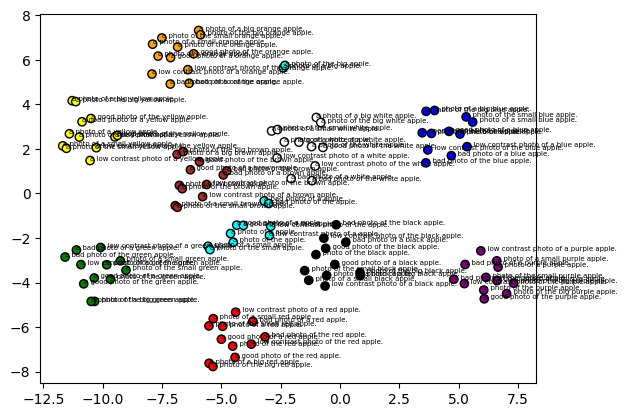

In [140]:
# Creating figure
# fig = plt.figure(figsize = (5, 5))

# plt.scatter(z[:,0], z[:,1], c=colors_list, edgecolors="black")
# plt.title("Color Embedding TSNE Visualization")
# # show plot
# plt.show()

fig, ax = plt.subplots()
ax.scatter(z[:,0], z[:,1], c=colors_list, edgecolors="black")

for i in range(len(z[:,0])):
    ax.annotate(colored_concept_list[i], (z[i,0], z[i,1]), size=5)

In [63]:
model, processor = load_model("clip")
prompts = load_templates("cifar100") # "custom"
prompts = [prompt for prompt in prompts if "blurry" not in prompt]
colors = np.random.randint(low=0, high=255, size=(32, 32, 3), dtype=np.uint8)
colors_to_test = ["red", "green", "blue", "purple", "yellow", "orange", "brown", "black", "white", "cyan"]

text_embedding_list = []
colors_list = []
colored_concept_list = []
concept_color = 0
concept = "apple"

for color in colors_to_test:
    colored_concept = f"{color} {concept}"
    if color == "cyan":
        colored_concept = concept
    
    encoded_image, text_embeddings = get_model_embeddings(colored_concept, prompts, colors, processor, model)
    text_embedding_list.extend([np.array(embed[0]) for embed in text_embeddings])
    colors_list.extend([color for i in range(len(encoded_image))])
    colored_concept_list.extend([prompt.replace("{}", colored_concept) for prompt in prompts])
    concept_color += 1

text_embedding_list = np.stack(text_embedding_list)

100%|██████████| 12/12 [00:01<00:00, 11.79it/s]


In [103]:
tsne = sklearn.manifold.TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(text_embedding_list)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.001s...
[t-SNE] Computed neighbors for 120 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 0.240132
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.504395
[t-SNE] KL divergence after 1000 iterations: 0.286411


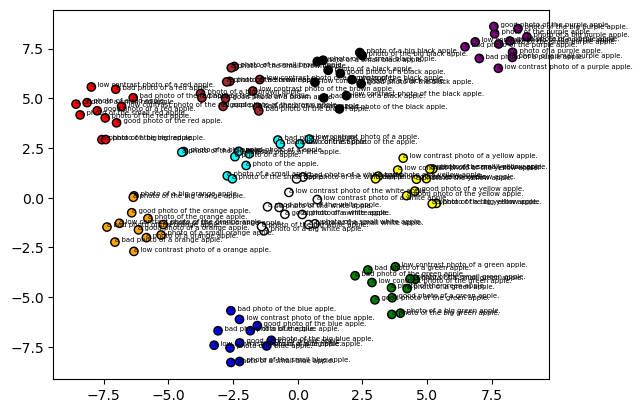

In [104]:
fig, ax = plt.subplots()
ax.scatter(z[:,0], z[:,1], c=colors_list, edgecolors="black")

for i in range(len(z[:,0])):
    ax.annotate(colored_concept_list[i], (z[i,0], z[i,1]), size=5)

# Processing Apple Image

(612, 612, 3)


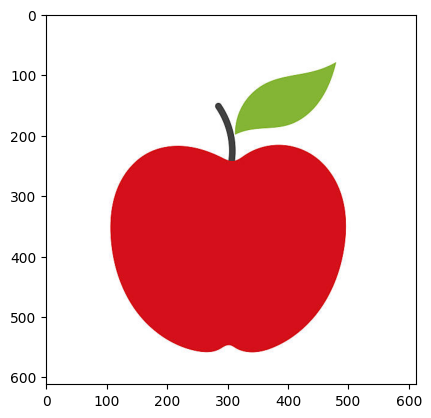

In [149]:
from PIL import Image
import matplotlib
  
filename = "data\\images\\apple_images\\apple_clipart.jpg"
with Image.open(filename) as image:
    apple_image = np.array(image)
    print(apple_image.shape)
plt.imshow(apple_image)
plt.show()

apple_mask = apple_image[:, :].sum(axis=2) < 200 * 3
background_mask = apple_image[:, :].sum(axis=2) >= 200 * 3

recolored_apple = np.array(image).astype("float")
apple_images, apple_color_name, background_color_name = [], [], []

for color1 in colors_to_test:
    if color1 == "cyan":
        continue
    for color2 in colors_to_test:
        if color1 == color2 or color2 == "cyan":
            continue
        recolored_apple[apple_mask] = matplotlib.colors.to_rgb(color1)
        recolored_apple[background_mask] = matplotlib.colors.to_rgb(color2)
#         plt.imshow(recolored_apple)
#         plt.show()
        apple_images.append(recolored_apple.copy() * 255)
        apple_color_name.append(color1)
        background_color_name.append(color2)


In [146]:
def plot_color_association_bar_chart(color_list, hist_values, title):
    plt.title(title)
    plt.bar(x=range(len(hist_values)), height=hist_values, color=color_list, edgecolor="black")
    plt.show()

In [144]:
def get_color_word_associations(text, colors):
    with torch.no_grad():
        inputs = processor(text=text, images=colors, return_tensors="pt", padding=True)
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
        logits_per_text = outputs.logits_per_text.softmax(dim=1)
        return logits_per_text

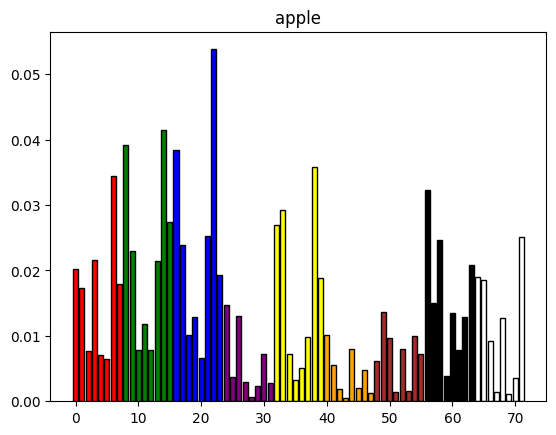

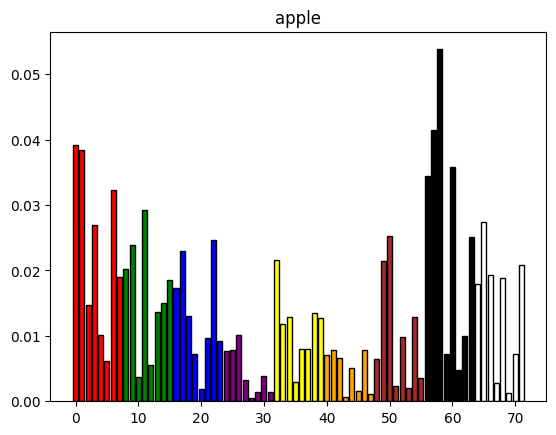

In [152]:
text = ["apple"]
cwa = get_color_word_associations(text, [apple_images[sample].transpose(2, 0, 1) for sample in range(len(apple_images))])

for word in range(cwa.shape[0]):
    plot_color_association_bar_chart([apple_images[sample][300, 300] / 255 for sample in range(len(apple_images))], 
                                    cwa[word].cpu().detach().numpy(),
                                    text[word])
    
background_rearranging = []
for color in colors_to_test:
    if color1 == "cyan":
        continue
    for i in range(len(background_color_name)):
        if background_color_name[i] == color:
            background_rearranging.append(i)
         
cwa = get_color_word_associations(text, [apple_images[sample].transpose(2, 0, 1) for sample in background_rearranging])
for word in range(cwa.shape[0]):
    plot_color_association_bar_chart([apple_images[sample][0, 0] / 255 for sample in background_rearranging], 
                                    cwa[word].cpu().detach().numpy(),
                                    text[word])

In [123]:
model, processor = load_model("clip")
prompts = load_templates("cifar100") # "custom"
colors_to_test = ["red", "green", "blue", "purple", "yellow", "orange", "brown", "black", "white"]
image_embeddings_list = []

for image in apple_images:
    encoded_image, text_embeddings = get_model_embeddings("apple", ["a {}"], [image.transpose(2, 0, 1)], processor, model)
#     encoded_image, text_embeddings = get_model_embeddings("apple", ["a {}"], (image * 255).astype("uint8"), processor, model)
    image_embeddings_list.append(np.array(encoded_image[0][0]))

image_embeddings_list = np.stack(image_embeddings_list)

100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


In [124]:
print(text_embedding_list.shape)
print(image_embeddings_list.shape)

(120, 512)
(72, 512)


In [131]:
def custom_dot(x, y):
    return np.dot(x, y)

all_embeddings = np.concatenate([text_embedding_list, image_embeddings_list])
# all_embeddings.shape
tsne = sklearn.manifold.TSNE(n_components=2, verbose=1, random_state=123, metric=custom_dot)
z = tsne.fit_transform(all_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 192 samples in 0.001s...
[t-SNE] Computed neighbors for 192 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 192 / 192
[t-SNE] Mean sigma: 0.064474
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.441780
[t-SNE] KL divergence after 1000 iterations: 1.231341


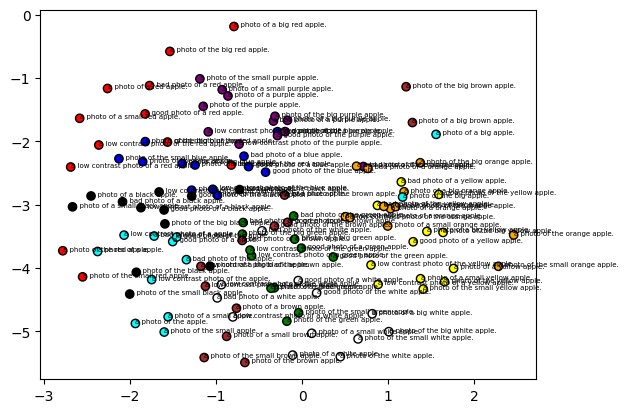

In [132]:
fig, ax = plt.subplots()
ax.scatter(z[:len(text_embedding_list),0], z[:len(text_embedding_list),1], c=colors_list, edgecolors="black")

for i in range(len(z[:len(text_embedding_list),0])):
    ax.annotate(colored_concept_list[i], (z[i,0], z[i,1]), size=5)

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [134]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

C:\Users\Cole\anaconda3\envs\color_word_association\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Cole\anaconda3\envs\color_word_association\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\Cole\AppData\Local\Temp\ipykernel_1224\371588706.py:26: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(x, y)
C:\Users\Cole\anaconda3\envs\color_word_association\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\Cole\anaconda3\envs\color_word_association\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Cole\anaconda3\envs\color_word_association\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
 

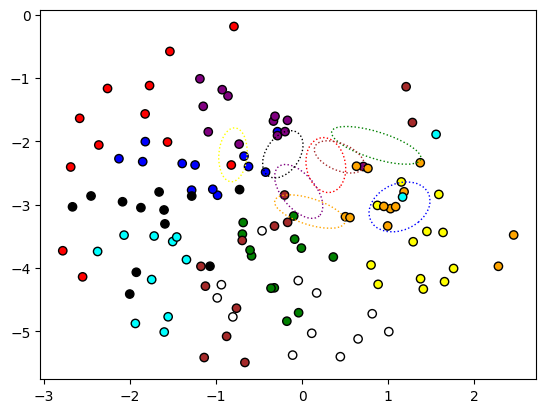

In [135]:
# fig, ax_nstd = plt.subplots(figsize=(6, 6))
fig, ax_nstd = plt.subplots()
ax_nstd.scatter(z[:len(text_embedding_list),0], z[:len(text_embedding_list),1], c=colors_list, edgecolors="black")

for color in range(len(colors_to_test)):
    start_idx, end_idx = len(text_embedding_list) + len(colors_to_test)*color, len(text_embedding_list) + len(colors_to_test)*(1+color)
    confidence_ellipse(z[start_idx:end_idx,0], z[start_idx:end_idx,1], ax_nstd, n_std=0.4,
                       label=colors_to_test[color], edgecolor=colors_to_test[color], linestyle=':')
plt.show()

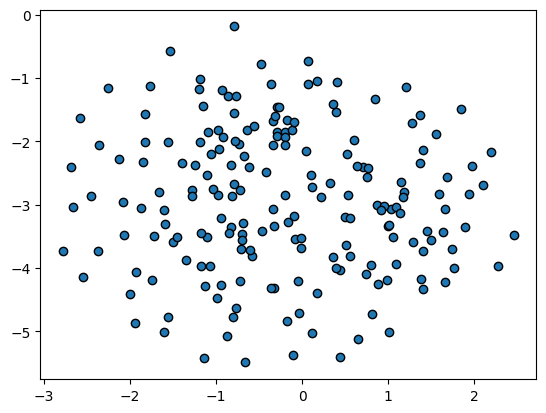

In [136]:
fig, ax_nstd = plt.subplots()
ax_nstd.scatter(z[:,0], z[:,1], edgecolors="black")
